# About

In this file, we perform a univariate time series analysis of the car crash dataset to compare 2020 rates to 'normal' years.

# Prepare Data for Time Series Analysis

Load cleaned dataset:

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from tbats import TBATS

# matplotlib settings
plt.rcParams["figure.figsize"] = (20,10)
font = {'size' : 22}
matplotlib.rc('font', **font)

# pandas settings
pd.set_option('display.max_columns',None)
pd.set_option('display.width',None)
pd.set_option('display.max_colwidth',None)

# location of cleaned dataset
crashpath = r'C:\CarCrash_analysis\CarCrashData'

In [2]:
# load data from disk
df = pd.read_csv(os.path.join(crashpath, 'CrashStatistics_cleaned.csv'), low_memory=False)
df.CrashDateTime = pd.to_datetime(df.CrashDateTime)
df['Year'] = df.CrashDateTime.dt.year
df['Month'] = df.CrashDateTime.dt.month
df['Day'] = df.CrashDateTime.dt.day
df['DayOfYear'] = df.CrashDateTime.dt.dayofyear

# drop data from 2021 (incomplete)
# df = df[df['Year'] < 2021]

# drop all but 2 columns to save memory
df = df[['CrashDateTime', 'LocalReportNumber']]

# make CrashDateTime the index, and sort by date
df.set_index(df.CrashDateTime,inplace=True)
df.drop(['CrashDateTime'], axis='columns', inplace=True)
df.sort_index(inplace=True)

Compute the daily, weekly and monthly number of crashes, statewide.

In [3]:
df_daily = df.resample(rule='1D',origin='start_day', label='left').count()  # daily no. of crashes
df_daily.columns = ['NumCrashes']
df_daily = df_daily[df_daily.index.year < 2021]

df_weekly = df.resample(rule='1W',origin='start_day', label='left').count()  # weekly no. of crashes
df_weekly.columns = ['NumCrashes']
df_weekly = df_weekly[df_weekly.index.year < 2021]

df_monthly = df.resample(rule='1M',origin='start_day', label='left').count()  # monthly no. of crashes
df_monthly.columns = ['NumCrashes']
df_monthly = df_monthly[df_monthly.index.year < 2021]

print(df_daily.head())
print(df_weekly.head())
print(df_monthly.head())

               NumCrashes
CrashDateTime            
2016-01-01            494
2016-01-02            487
2016-01-03            510
2016-01-04            938
2016-01-05            789
               NumCrashes
CrashDateTime            
2015-12-27           1491
2016-01-03           6395
2016-01-10           7197
2016-01-17           6137
2016-01-24           4831
               NumCrashes
CrashDateTime            
2015-12-31          26051
2016-01-31          24572
2016-02-29          22215
2016-03-31          24310
2016-04-30          24841


Plot the number of crashes vs. time:

In [4]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(df_daily.index, df_daily.NumCrashes)
ax[0].set_ylabel('Daily')
ax[0].grid()

ax[1].plot(df_weekly.index, df_weekly.NumCrashes)
ax[1].set_ylabel('Weekly')
ax[1].grid()

ax[2].plot(df_monthly.index, df_monthly.NumCrashes)
ax[2].set_ylabel('Monthly')
ax[2].grid()

ax[-1].set_xlim(df_daily.index.min(), df_daily.index.max())
ax[-1].set_xlabel('CrashDateTime')
ax[0].set_title('Statewide Car Crashes')
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.1)
plt.show()

With the exception of 2020, we see a strong annual pattern in the data. This can be shown by plotting each year's data on the same scale:

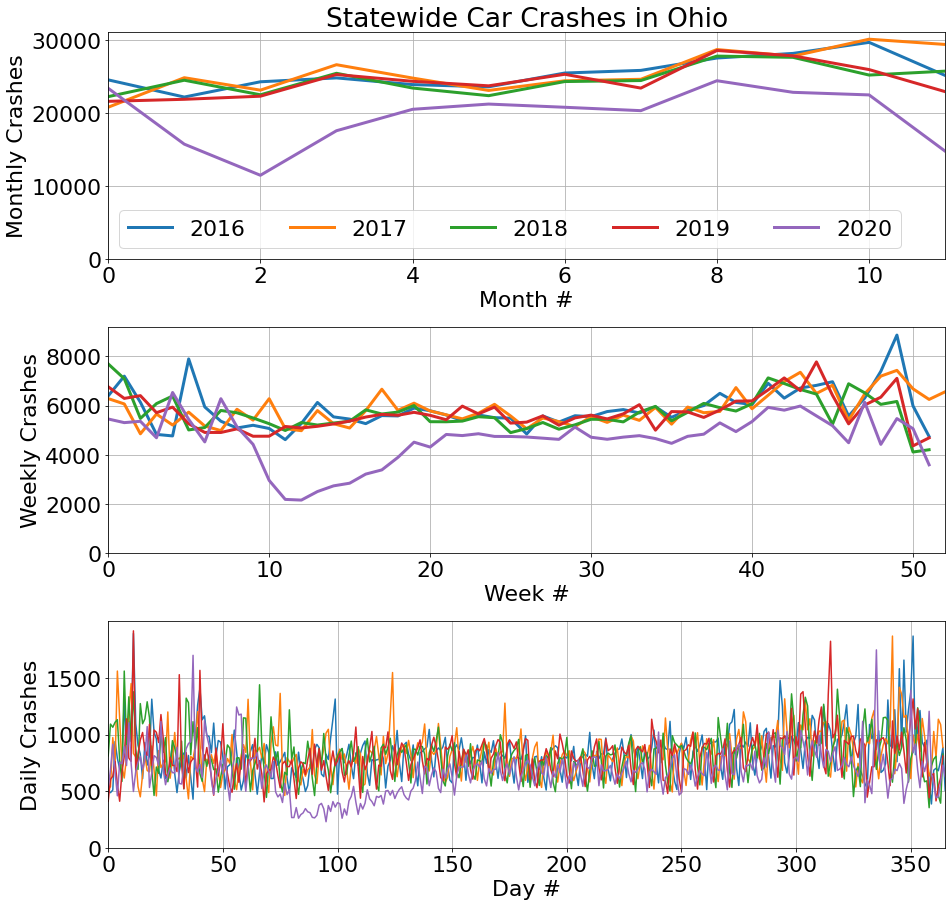

In [5]:
fig, ax = plt.subplots(3, figsize=(15,15))
for yr in df_daily.index.year.unique():
    ax[0].plot(df_monthly.NumCrashes[df_monthly.index.year==yr].values, lw=3, label=yr)
    ax[1].plot(df_weekly.NumCrashes[df_weekly.index.year==yr].values, lw=3, label=yr)
    ax[2].plot(df_daily.NumCrashes[df_daily.index.year==yr].values, label=yr)

ax[0].legend(frameon=True, ncol=6)
ax[0].set_xlim(0, 11)
ax[0].set_ylim(0)
ax[0].set_xlabel('Month #')
ax[0].set_ylabel('Monthly Crashes')
ax[0].set_title('Statewide Car Crashes in Ohio')
ax[0].grid()

ax[1].set_xlim(0, 52)
ax[1].set_ylim(0)
ax[1].set_xlabel('Week #')
ax[1].set_ylabel('Weekly Crashes')
ax[1].grid()

ax[2].set_xlim(0, 365)
ax[2].set_ylim(0)
ax[2].set_xlabel('Day #')
ax[2].set_ylabel('Daily Crashes')
ax[2].grid()

plt.subplots_adjust(hspace=0.3)
plt.show()

# Holt-Winters Exponential Smoothing (HWES)

Exponential smoothing is a commonly used univariate time series analysis method that uses weighted past observations to forecast future data points. We will briefly introduce the core concepts behind the Holt-Winters seasonal method below. An introductory reference can be found [here](https://otexts.com/fpp2/holt-winters.html).

Suppose we have a set of observations with $y_t$ denoting the observed value at time $t$. Let the observed signal be well described by an average value (the "level"), a slowly changing function (the "trend"), and a periodic function with period $m$ (the "seasonality"). Depending on the nature of the signal, the magnitude of the seasonality component can either be independent of ("addititive") or proportional to ("multiplicative") the trend and level. That is, we can write the following:

\begin{align}
\text{additive:} \quad &\text{signal = levels + trends + seasonality} \\
\text{multiplicative:} \quad &\text{signal = (levels + trends) $\times$ seasonality}
\end{align}

Mathematically, the additive model of the Holt-Winters seasonal method is expressed iteratively:

\begin{align}
\text{forecast:}& \quad \hat{y}_{t+h|t} = l_t + h b_t + s_{t+h-m(k+1)}, \\
\text{level:}& \quad l_t = \alpha ( y_t - s_{t - m}) + (1-\alpha)(l_{t-1} + b_{t-1}), \\
\text{trend:}& \quad b_t = \beta^* (l_t - l_{t-1}) + (1-\beta^*) b_{t-1}, \\
\text{seasonality:}& \quad s_t = \gamma ( y_t - l_{t-1} - b_{t-1} ) + (1-\gamma) s_{t-m},
\end{align}

where $\hat{y}_{t+h|t}$ is the forecast at time $t+h$, given all the previous observations $(y_1, \ldots, y_t)$. The symbol $k$ denotes the integer part of $(h-1)/m$, which ensures that the estimates of the seasonal indices used for forecasting come from the final period of the sample.

The structure of the above equations becomes clear when we recall that HWES uses an exponential window to give the predicted signal a "memory" of past results, using weighting factors $\alpha, \beta^*$ and $\gamma$:

- The level equation is a weighted average between the seasonally adjusted observation $( y_t - s_{t - m})$ and the non-seasonal forecast $(l_{t-1} + b_{t-1})$ for time $t$.
- The trend is a weighted average between the change in level $(l_t - l_{t-1})$ and the previous trend observation.
- The seasonality is a weighted average between the current seasonal term $( y_t - l_{t-1} - b_{t-1} )$ and the value from the previous season $(s_{t-m})$.

Likewise, the multiplicative model is expressed as:

\begin{align}
\text{forecast:}& \quad \hat{y}_{t+h|t} = (l_t + h b_t) s_{t+h-m(k+1)} \\
\text{level:}& \quad l_t = \alpha \frac{y_t}{s_{t - m}} + (1-\alpha)(l_{t-1} + b_{t-1}) \\
\text{trend:}& \quad b_t = \beta^* (l_t - l_{t-1}) + (1-\beta^*) b_{t-1} \\
\text{seasonality:}& \quad s_t = \gamma \frac{y_t}{l_{t-1} + b_{t-1}} + (1-\gamma) s_{t-m}
\end{align}

Below, we will apply the Holt-Winters model to the number of observed car crashes.

In [6]:
df_weekly['HWES3_ADD'] = ExponentialSmoothing(
    df_weekly['NumCrashes'],
    trend='add',
    seasonal='add',
    seasonal_periods=52).fit().fittedvalues

df_weekly['HWES3_MUL'] = ExponentialSmoothing(
    df_weekly['NumCrashes'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=52).fit().fittedvalues

fig, ax = plt.subplots()
ax.plot(df_weekly.index, df_weekly.NumCrashes, label='NumCrashes')
ax.plot(df_weekly.index, df_weekly.HWES3_ADD, label='HWES3_ADD')
ax.plot(df_weekly.index, df_weekly.HWES3_MUL, label='HWES3_MUL')
ax.set_ylabel('Weekly Crashes')
ax.grid()
ax.legend(frameon=True, ncol=3)
ax.set_xlabel('CrashDateTime')
ax.set_xlim(df_weekly.index.min(), df_weekly.index.max())
ax.set_title('Holt-Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')

plt.show()

C:\Users\smith\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\smith\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


At a glance, it looks like HWES is able to reproduce our data reasonably well.

Let's split the data into training (2015 - 2018) and testing datasets (2019). The 2020 data will be excluded from this discussion because of its abnormal behavior. We will use the weekly number of crashes to suppress the high-frequency oscillations (more on this later).

In [7]:
train = df_weekly[df_weekly.index.year<2019].dropna()
test = df_weekly[df_weekly.index.year==2019].dropna()
pred = df_weekly[df_weekly.index.year==2020].dropna()

C:\Users\smith\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\smith\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


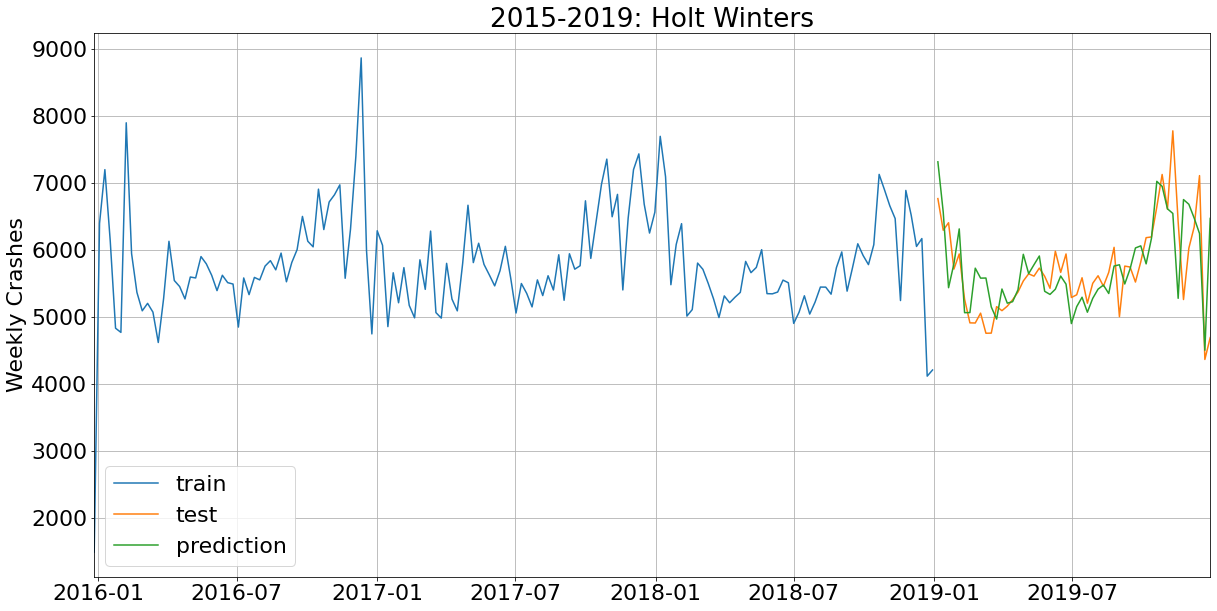

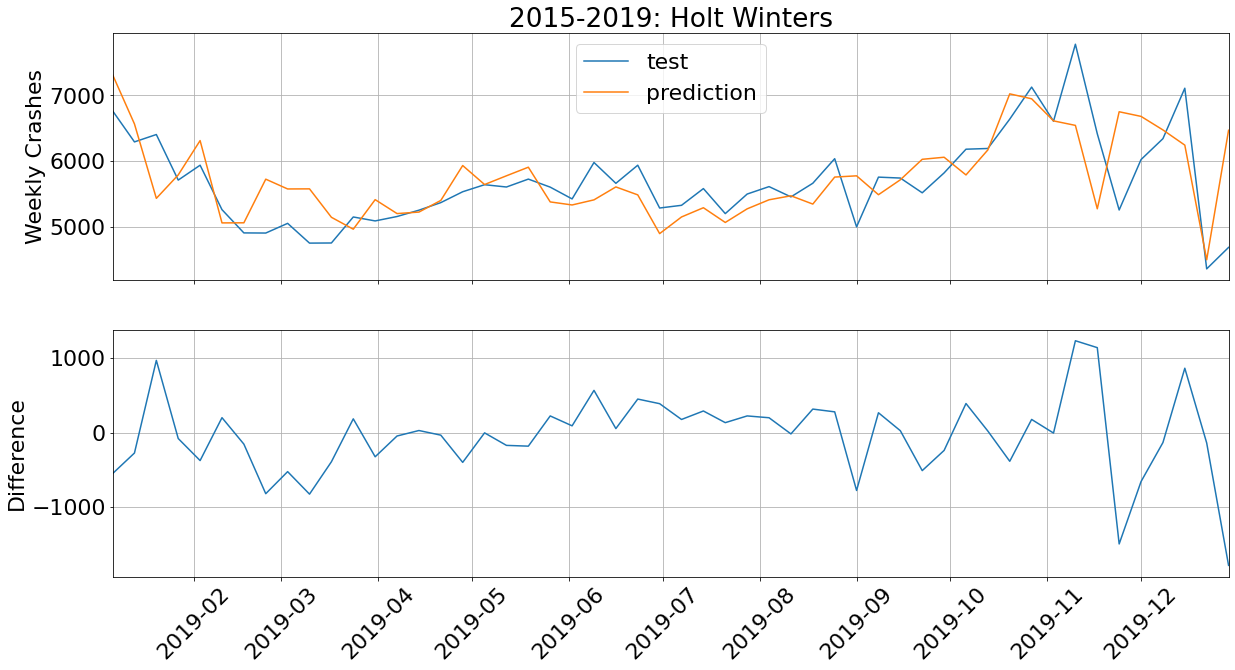

In [8]:
# train HWES on 2016-2018 data
fitted_model = ExponentialSmoothing(
    train['NumCrashes'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=52).fit()

# test on 2019 data
test_predictions = fitted_model.forecast(52)

# plot all data
fig, ax = plt.subplots()
ax.plot(train.index, train.NumCrashes, label='train')
ax.plot(test.index, test.NumCrashes, label='test')
ax.plot(test.index, test_predictions, label='prediction')
ax.set_title('2015-2019: Holt Winters')
ax.set_ylabel('Weekly Crashes')
ax.set_xlim(train.index.min(), test.index.max())
ax.grid()
ax.legend(frameon=True)
plt.show()

# zoom in on the test date range
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(test.index, test.NumCrashes, label='test')
ax[0].plot(test.index, test_predictions, label='prediction')
ax[1].plot(test.index, test.NumCrashes-test_predictions)
ax[1].set_ylabel('Difference')
ax[0].set_title('2015-2019: Holt Winters')
ax[0].set_ylabel('Weekly Crashes')
ax[0].set_xlim(test.index.min(), test.index.max())
ax[0].grid()
ax[0].legend(frameon=True)
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid()
plt.show()

We quantify the fitting error using the room mean square error (RMSE):

In [9]:
print(f'Holt-Winters RMSE (weekly) = {np.sqrt(mean_squared_error(y_true=test.NumCrashes, y_pred=test_predictions)):3.1f}')

Holt-Winters RMSE (weekly) = 546.7


What happens if we try to use the daily number of crashes?

C:\Users\smith\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\smith\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


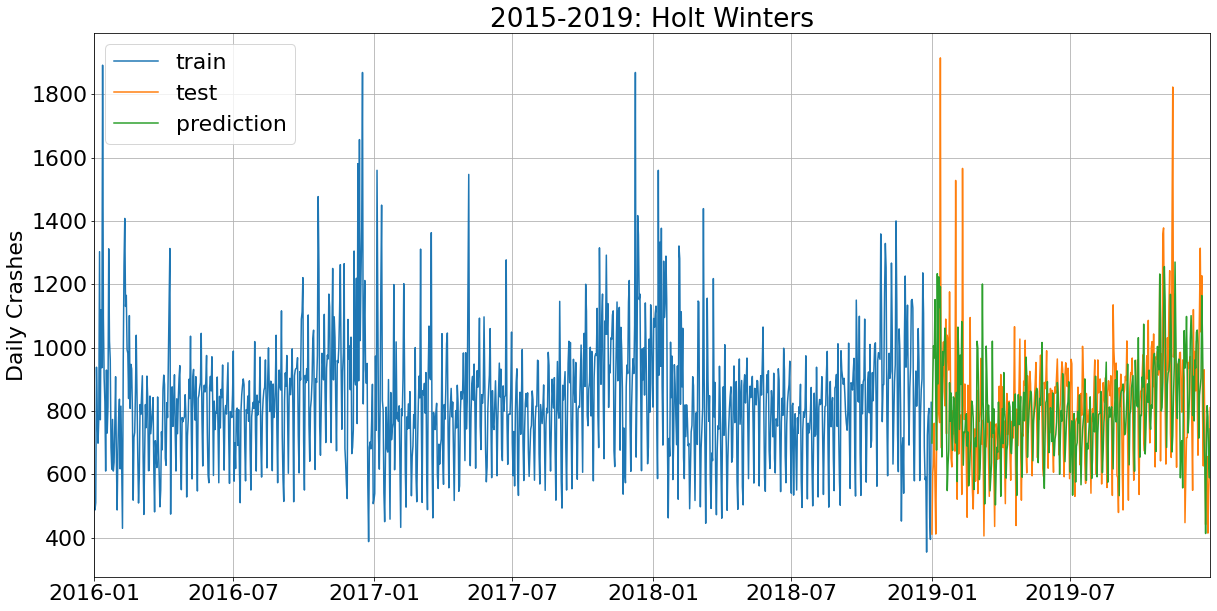

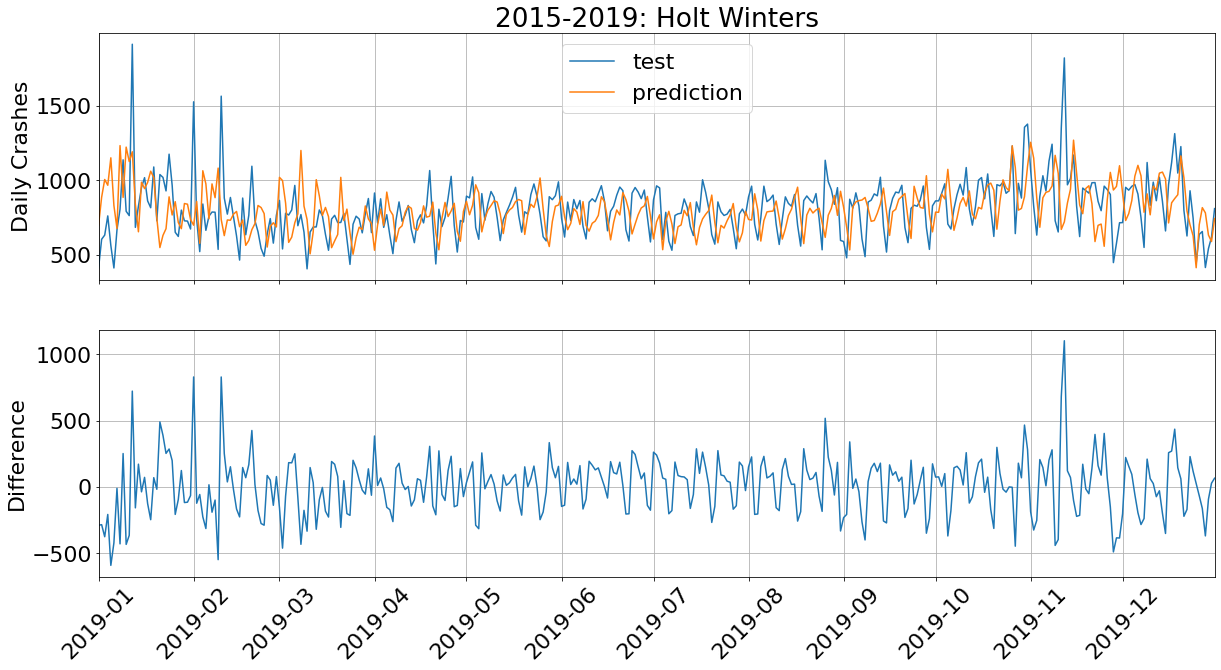

Holt-Winters RMSE (daily) = 219.9


In [10]:
train = df_daily[df_daily.index.year<2019].dropna()
test = df_daily[df_daily.index.year==2019].dropna()
pred = df_daily[df_daily.index.year==2020].dropna()

# train HWES on 2016-2018 data
fitted_model = ExponentialSmoothing(
    train['NumCrashes'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=365).fit()

# test on 2019 data
test_predictions = fitted_model.forecast(365)

# plot all data
fig, ax = plt.subplots()
ax.plot(train.index, train.NumCrashes, label='train')
ax.plot(test.index, test.NumCrashes, label='test')
ax.plot(test.index, test_predictions, label='prediction')
ax.set_title('2015-2019: Holt Winters')
ax.set_ylabel('Daily Crashes')
ax.set_xlim(train.index.min(), test.index.max())
ax.grid()
ax.legend(frameon=True)
plt.show()

# zoom in on the test date range
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(test.index, test.NumCrashes, label='test')
ax[0].plot(test.index, test_predictions, label='prediction')
ax[1].plot(test.index, test.NumCrashes-test_predictions)
ax[1].set_ylabel('Difference')
ax[0].set_title('2015-2019: Holt Winters')
ax[0].set_ylabel('Daily Crashes')
ax[0].set_xlim(test.index.min(), test.index.max())
ax[0].grid()
ax[0].legend(frameon=True)
ax[1].grid()
ax[1].tick_params(axis='x', rotation=45)
plt.show()

print(f'Holt-Winters RMSE (daily) = {np.sqrt(mean_squared_error(y_true=test.NumCrashes, y_pred=test_predictions)):3.1f}')

# Frequency Analysis

Let's take a closer look at the frequencies in the data. We will perform a Fourier analysis to identify the dominant frequencies. Again, we exclude 2020 due to the abnormal behavior:

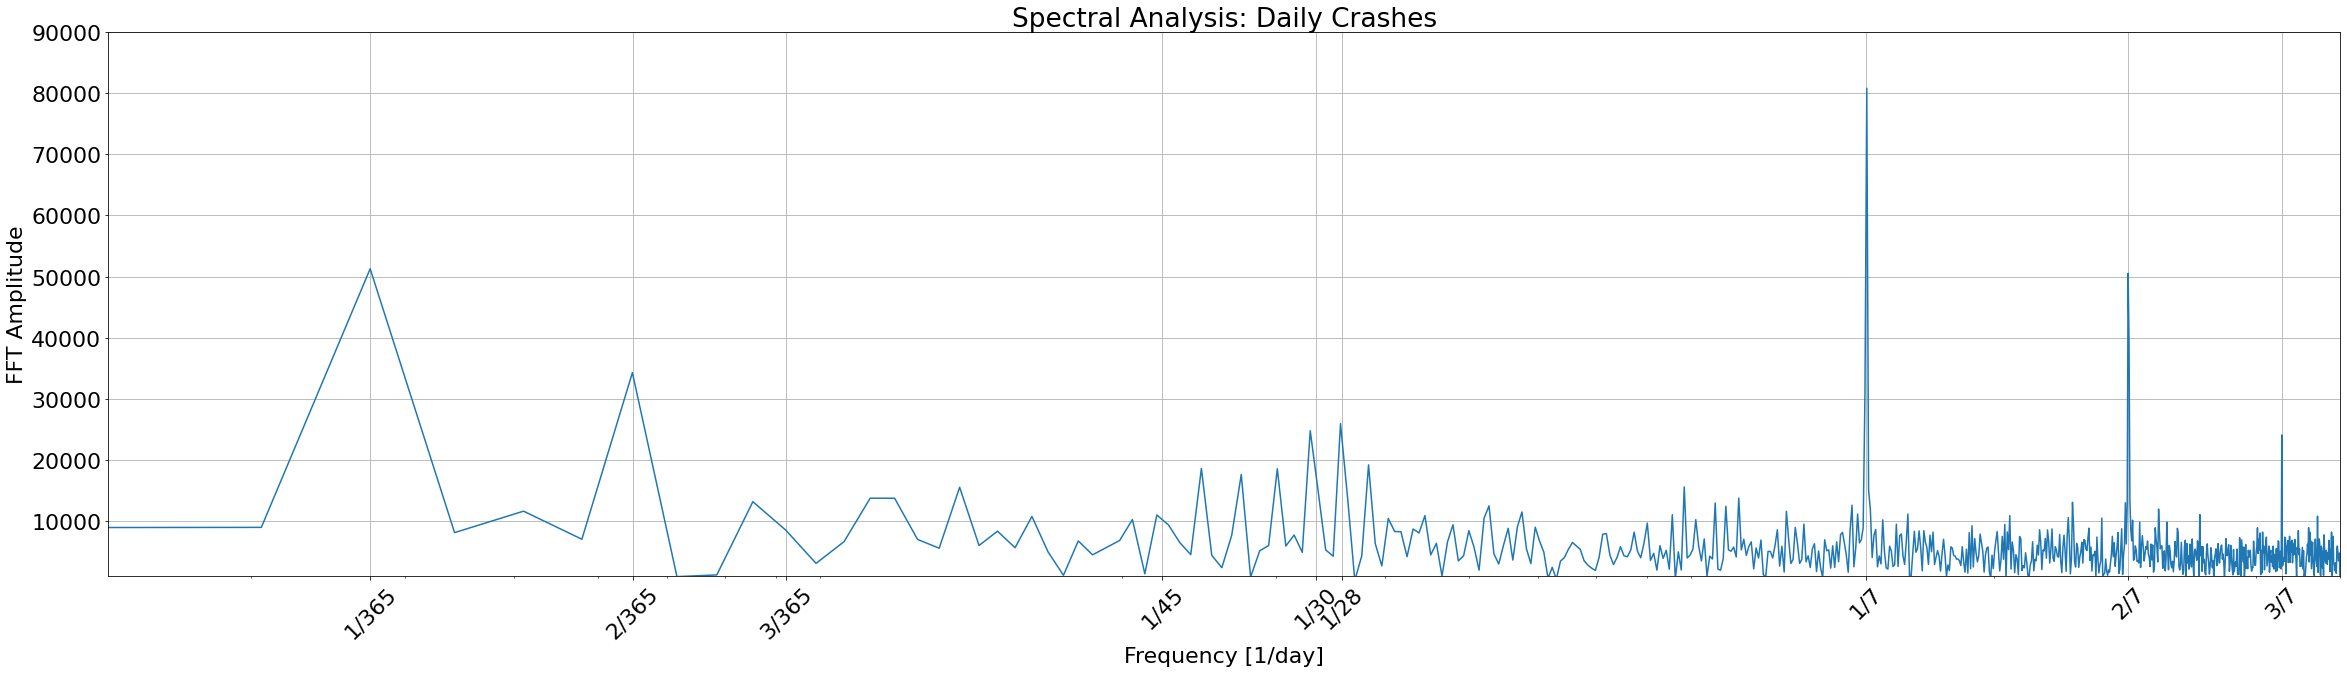

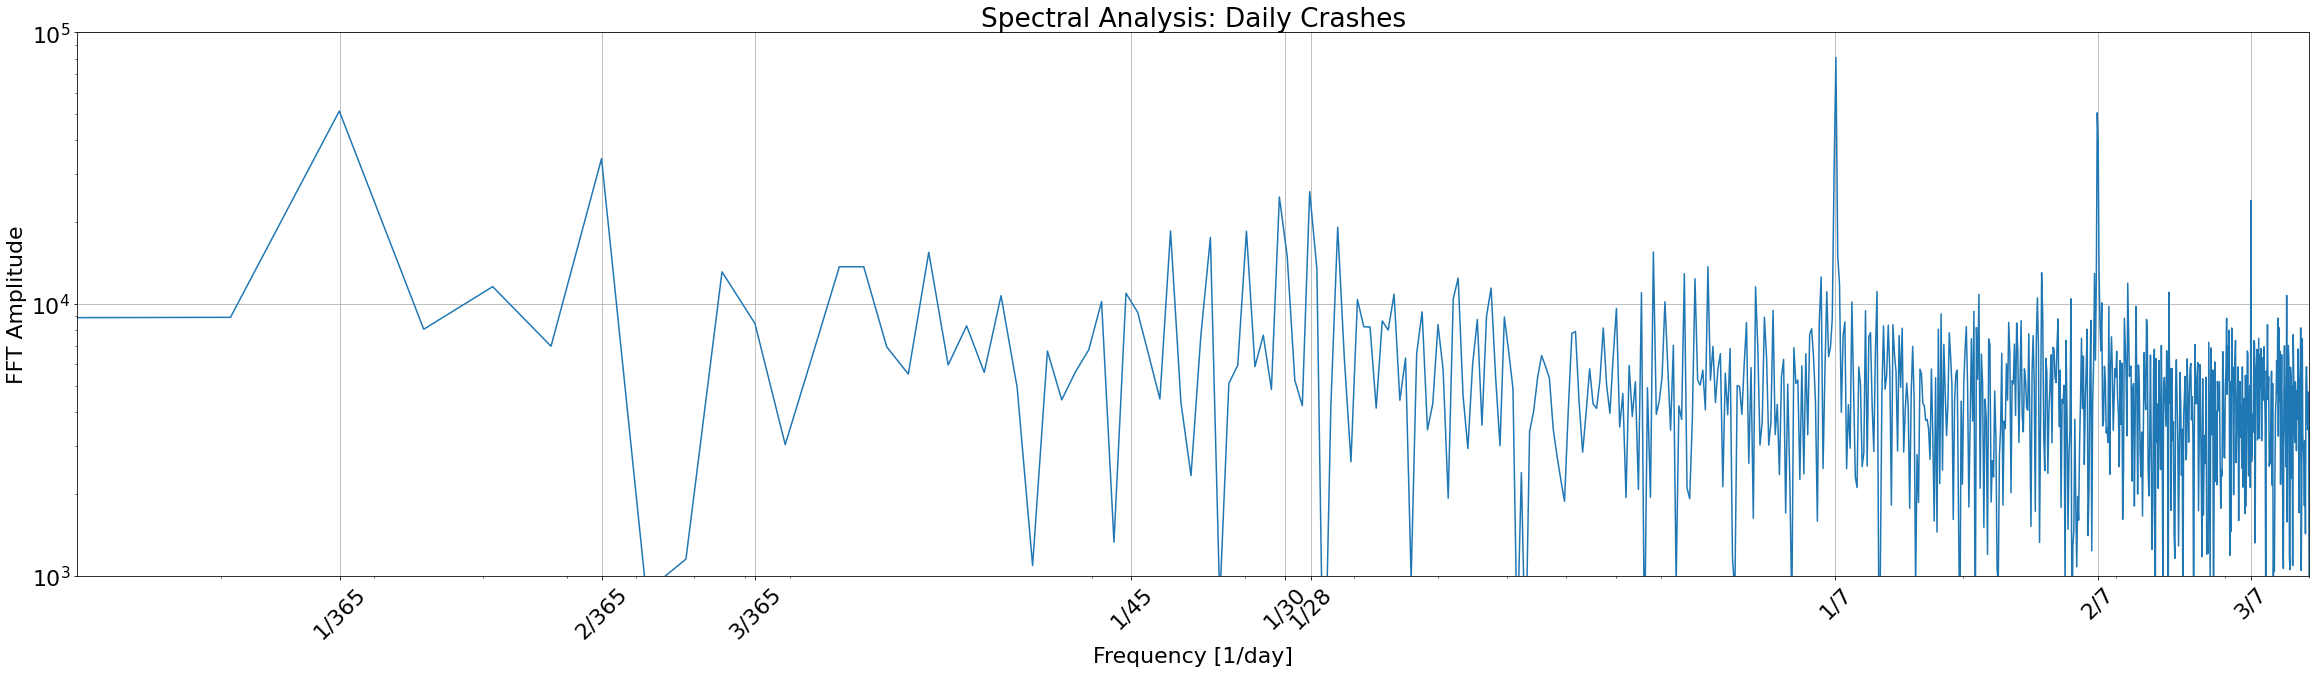

In [11]:
def fft_wrapper(df, timestep=1):
    """
    Convenience function for FFT.
    timestep is sample spacing in days.
    """
    n = df[df.index.year<2020].size  # number of sample points
    timestep = 1  # sample spacing [days]
    yf = np.fft.rfft(df[df.index.year<2020].NumCrashes)
    freq = np.fft.rfftfreq(n, d=timestep)
    return yf, freq

def tick_wrapper(start=2, stop=365, num=20):
    # custom x-tick labels
    myxticks = [1/i for i in np.geomspace(start, stop, num=num)]
    myxlabels = [f'1/{i:2.1f}' for i in np.geomspace(start, stop, num=num)]
    return myxticks, myxlabels

yf_daily, freq_daily = fft_wrapper(df_daily, timestep=1)
# myxticks, myxlabels = tick_wrapper(start=2, stop=2*365, num=20)

myxticks = [1/7, 2/7, 3/7, 1/365, 2/365, 3/365, 1/45, 1/30, 1/28]
myxlabels = ['1/7', '2/7', '3/7', '1/365', '2/365', '3/365', '1/45', '1/30', '1/28']

fig, ax = plt.subplots(figsize=(40,10))
ax.semilogx(freq_daily, np.abs(yf_daily))
ax.set_xlabel('Frequency [1/day]')
ax.set_ylabel('FFT Amplitude')
ax.set_title('Spectral Analysis: Daily Crashes')
ax.set_xticks(myxticks)
ax.set_xticklabels(myxlabels)
ax.set_xlim(1/(2*365), 1/2)
ax.set_ylim(1e3, 9e4)
ax.tick_params(axis='x', rotation=45)
ax.grid()
plt.show()

fig, ax = plt.subplots(figsize=(40,10))
ax.loglog(freq_daily, np.abs(yf_daily))
ax.set_xlabel('Frequency [1/day]')
ax.set_ylabel('FFT Amplitude')
ax.set_title('Spectral Analysis: Daily Crashes')
ax.set_xticks(myxticks)
ax.set_xticklabels(myxlabels)
ax.set_xlim(1/(2*365), 1/2)
ax.set_ylim(1e3, 1e5)
ax.tick_params(axis='x', rotation=45)
ax.grid()
plt.show()

We see spikes in the FFT amplitude 1/7 and 1/365 inverse days, plus subharmonics of those frequencies. This tells us there is a strong weekly and annual component to the data.The broad hump between 1/2 inverse weeks and 1/6 inverse weeks indicates slower trends.

Another way to see the annual trend is to plot the root mean square error (RMSE) of a seasonal decomposition of the weekly data vs. the assumed period:

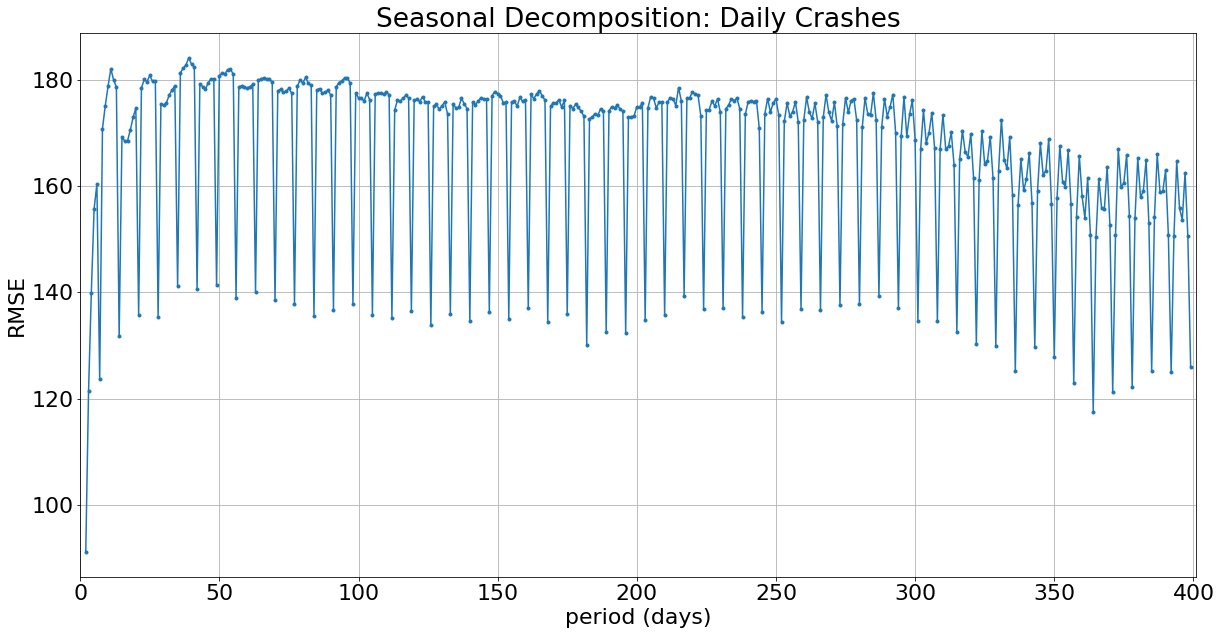

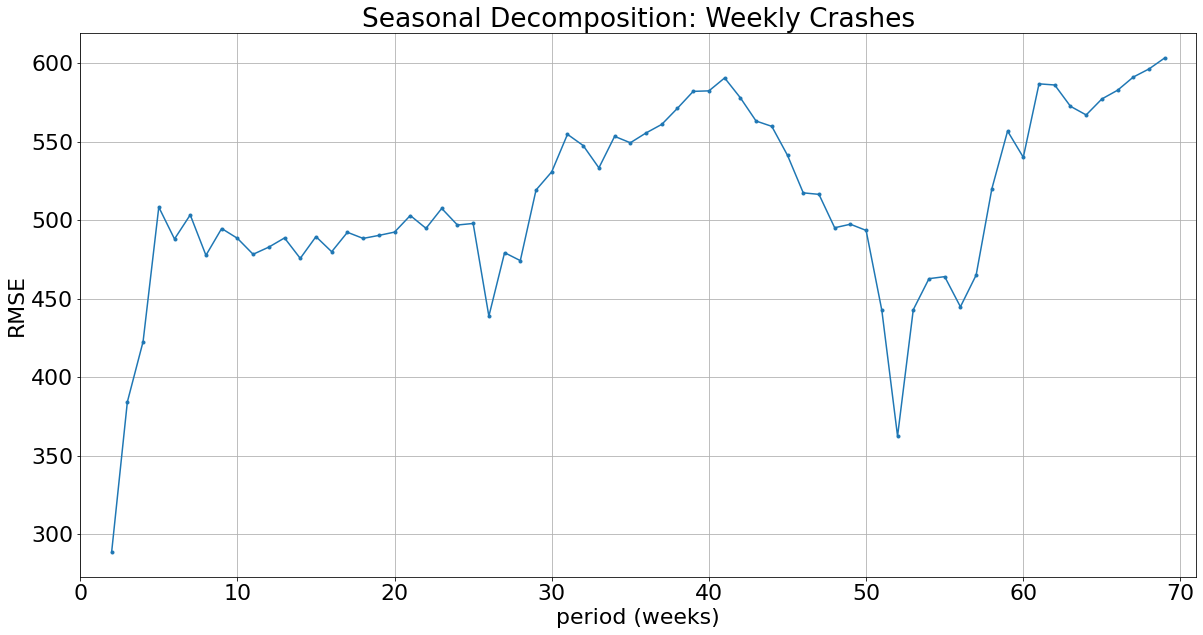

In [12]:
def season_decomp_loop(df, pmax):
    err = []
    myper = np.arange(2, pmax)
    for p in myper:
        decompose_result = seasonal_decompose(df[df.index.year<2020].NumCrashes, model="additive", period=int(p))
        trend = decompose_result.trend
        seasonal = decompose_result.seasonal
        residual = decompose_result.resid
        size = residual.dropna().shape[0]
        err.append(np.sqrt((residual.dropna()**2).values.sum()/size))
    return myper, err, pmax

myper, err, pmax = season_decomp_loop(df_daily, 400)

fig, ax = plt.subplots()
ax.plot(myper, err, '.-')
ax.grid()
ax.set_xlabel('period (days)')
ax.set_ylabel('RMSE')
ax.set_title('Seasonal Decomposition: Daily Crashes')
ax.set_xlim(0, pmax+1)
plt.show()

myper, err, pmax = season_decomp_loop(df_weekly, 70)

fig, ax = plt.subplots()
ax.plot(myper, err, '.-')
ax.grid()
ax.set_xlabel('period (weeks)')
ax.set_ylabel('RMSE')
ax.set_title('Seasonal Decomposition: Weekly Crashes')
ax.set_xlim(0, pmax+1)
plt.show()

The dips every 7 days indicate weekly periodicity; the dips at 52 and 26 weeks indicate an annual and biannual periodicity.

# Notes on SARIMA modeling

SARIMA is a seasonal extension of the popular ARIMA model

A good intro book reference for ARIMA is [linked here](https://otexts.com/fpp2/seasonal-arima.html), and a blog post on python implementation is [linked here](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/).

python implementation (pmdarima) user guide [linked here](https://alkaline-ml.com/pmdarima/user_guide.html).

stationarity, unit root test

we use the augmented dickey-fuller test to check for stationarity.

backshift (also called "lags", $L$) notation, $B$:
$$
B y_t = y_{t-1}
$$

the $B$ operator can be treated algebraically
$$
B(By_t) = B^2 y_t = y_{t-2}
$$

differencing can be expressed using $B$:
\begin{align}
y'_t &= y_t - y_{t-1} = y_t - B y_t = (1-B) y_t \\
y''_t &= y_t - 2 y_{t-1} + y_{t-2} = (1-2B + B^2)y_t = (1-B)^2 y_t \\
y^{(d)}_t &= (1-B)^d y_t
\end{align}

the notation $AR(p)$ means an *autoregressive model* of order $p$:
\begin{align}
y_t &= c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t \\
&= c + \epsilon_t + \sum_{i=1}^p \phi_i y_{t-i} \\
&= c + \epsilon_t + \sum_{i=1}^p \phi_i B^i y_t
\end{align}
where $\epsilon_t$ is white noise. You can think of an autoregressive model as a regression model of a variable against past versions of itself.

$MA(q)$ denotes a *moving average model* of order $q$:
\begin{align}
y_t &= c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} \\
&= c + \epsilon_t + \theta_1 B \epsilon_t + \theta_2 B^2 \epsilon_t + \cdots + \theta_q B^q \epsilon_t \\
&= c + \left( 1 + \sum_{i=1}^q \theta_i B^i \right) \epsilon_t
\end{align}
where, again, $\epsilon_t$ is white noise. Note: this is different from a moving average smoothing model! You can think of a moving average model as a weighted moving average of the past few forecast errors.

An ARIMA (is an acronym for AutoRegressive Integrated Moving Average) model on $y$ is a combination of autoregression and moving average models on the differenced observation. The notation for this model is $ARIMA(p,d,q)$, and it is expressed as:

$$
y^{(d)}_t = c + \phi_1 y'_{t-1} + \cdots + \phi_p y'_{t-p} + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

where
- $y^{(d)}_t$ is the differenced series, and $d$ is the degree of first differencing
- $p$ is the order of the autoregressive part,
- $q$ is the order of the moving average part.

We can express the ARIMA equation using the backshift notation:
\begin{align}
(1 - \phi_1 B - \cdots - \phi_p B^p) (1-B)^d y_t &= c + (1 + \theta_1 B + \cdots + \theta_q B^q) \epsilon_t \\
\Leftrightarrow AR(p) \ (d \ \text{differences}) y_t &= MA(q)
\end{align}

In words, an ARIMA model is:

"predicted differenced (up to $d$ times) $y_t$ = constant + linear combination of lags of $y$ (up to $p$ lags) + linear combination of lagged forecast errors (up to $q$ lags)"



A SARIMA model adds seasonality to an ARIMA model. It is denoted as $ARIMA \ (p,d,q) \ (P,D,Q)_m$, where $(p,d,q)$ refers to the non-seasonal ARIMA part, and $(P, D, Q)_m$ is the seasonal part with periodicity $m$.

The general form of an $ARIMA(p,d,q)(P,D,Q)_m$ model is:

$$
\left(1-\sum_{i=1}^p \phi_i B^i \right)\left(1-\sum_{i=1}^P \phi_i B^{im} \right)(1-B)^d(1-B^m)^D y_t = \left(1+ \sum_{i=1}^q\theta_i B^i\right) \left(1+ \sum_{i=1}^Q \Theta_i B^{mi} \right) \epsilon_t + c
$$

For example, an $ARIMA(1,1,1)(1,1,1)_4$ model (without a constant) can be written as:
$$
(1-\phi_1 B)(1-\Phi_1 B^4)(1-B)(1-B^4) y_t = (1+\theta_1 B)(1+\Theta_1 B^4)\epsilon_t
$$

# SARIMA modeling in pmdarima

[pmdarima](https://alkaline-ml.com/pmdarima/index.html) is a python implementation of R's auto.arima. We will use it to model the number of daily car crashes.

In [13]:
import pmdarima as pm
from pmdarima.utils import tsdisplay
from pmdarima.preprocessing import LogEndogTransformer
from pmdarima.preprocessing import BoxCoxEndogTransformer
from scipy.stats import normaltest
from pmdarima.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
print(f'pmdarima version: {pm.__version__}')

pmdarima version: 1.8.0


Train and test on the normal years:

In [14]:
train = df_daily[df_daily.index.year<2019].dropna()
test = df_daily[df_daily.index.year==2019].dropna()

In [15]:
def plot_forecasts(forecasts, title):
    """Convenience function for plotting."""
    fig, ax = plt.subplots(2, sharex=True)
    # ax.plot(train.index, train.NumCrashes)
    ax[0].plot(test.index, test.NumCrashes)
    ax[0].grid()
    ax[0].plot(test.index, forecasts)

    resid = test.NumCrashes - forecasts
    ax[1].plot(test.index, resid)
    ax[1].grid()

    ax[-1].set_xlim(test.index.min(), test.index.max())
    ax[-1].tick_params(axis='x', rotation=45)
    ax[0].set_title(title)
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(resid, bins=30)
    plt.show()
    return

def forecast_wrapper(fit_model, test):
    preds = fit_model.predict(n_periods=test.shape[0])
    resid = test.NumCrashes - preds
    _, p = normaltest(resid)
    plot_forecasts(preds, '')
    print(f'RMSE: {np.sqrt(mse(preds, test.NumCrashes)):3.2f}')
    return

Look at the data:

C:\Users\smith\anaconda3\lib\site-packages\pmdarima\utils\visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


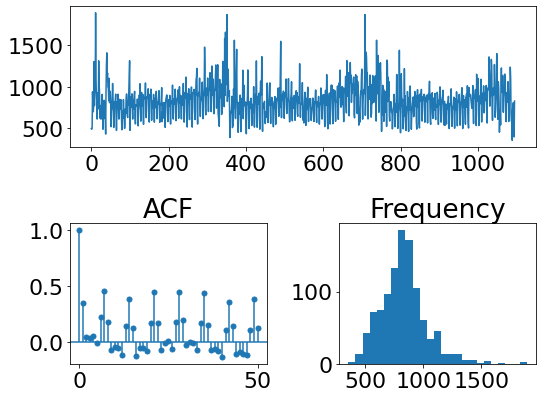

normal test: [4.1847109e-42]


In [16]:
tsdisplay(train)
print(f'normal test: {normaltest(train)[1]}')

The distribution is skewed, but let's try fitting it anyway. Let's use a weekly period (m=7):

In [17]:
fit1 = pm.auto_arima(train, m=7, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=14285.038, Time=1.98 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14711.458, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=14353.997, Time=0.91 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14428.983, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=17908.487, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=14428.628, Time=1.09 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=14358.231, Time=1.84 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=14297.890, Time=3.62 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=14306.588, Time=9.30 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=14569.118, Time=0.33 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=14389.185, Time=6.24 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=14286.265, Time=2.84 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=13.89 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.67 sec
 ARIMA(2,0,1)(1,0,1)[7] interc

In [18]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1096
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -7134.519
Date:                             Mon, 08 Feb 2021   AIC                          14285.038
Time:                                     13:24:01   BIC                          14325.034
Sample:                                          0   HQIC                         14300.172
                                            - 1096                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    500.6368     96.365      5.195      0.000     311.765     689.509
ar.L1         -1.5455      0.032    -48.210      0.000      -1.608      -1.483
ar.L2         -0.7962      0.031    -26.063      0.000      -0.856      -0.736
ma.L1          1.6850      0.020     84.046      0.000       1.646       1.724
ma.L2          0.9344      0.020     46.824      0.000       0.895       0.974
ar.S.L7        0.8201      0.034     24.285      0.000       0.754       0.886
ma.S.L7       -0.5072      0.053     -9.534      0.000      -0.611      -0.403
sigma2      3.086e+04    915.600     33.701      0.000    2.91e+04    3.27e+04
===================================================================================
Ljung-Box (L1) (Q):                  43.02   Jarque-Bera (JB):              2582.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             1.46
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So, we can get an AIC of 14,285.038 (m=7) without doing any transformations on the data. Let's see how well 

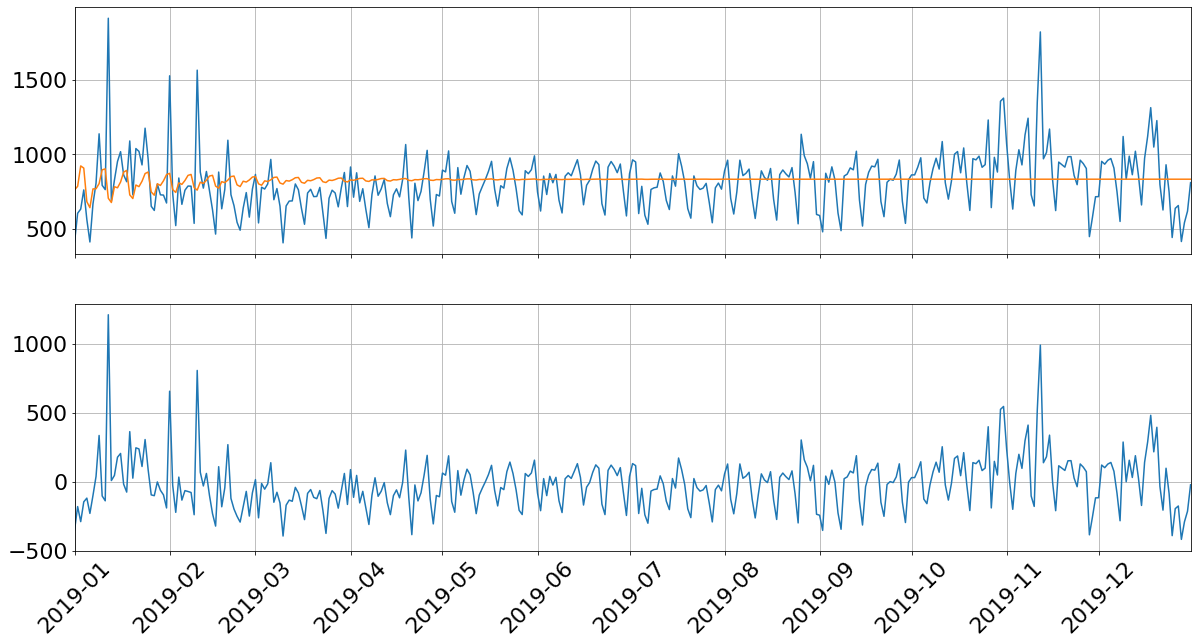

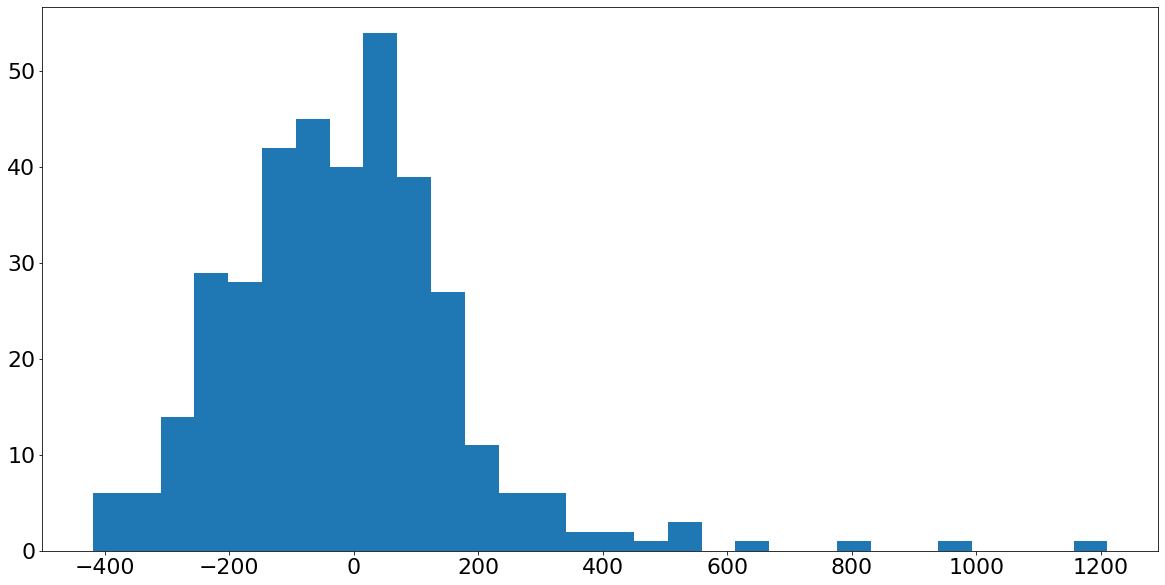

RMSE: 192.92


In [19]:
forecast_wrapper(fit1, test)

So, it's a horrible fit. Let's try applying a transformation to the data first. We'll start with a log transform:

C:\Users\smith\anaconda3\lib\site-packages\pmdarima\utils\visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


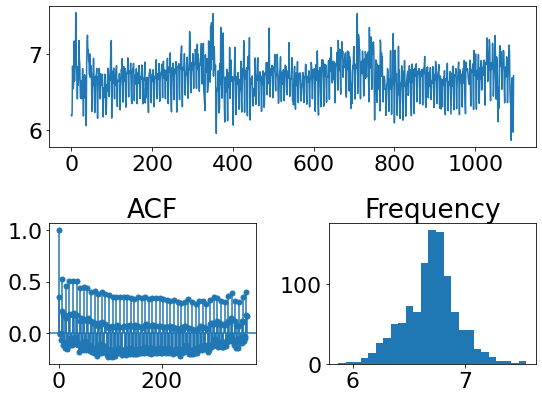

normal test: 0.006151138375799218


In [20]:
train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(train)
tsdisplay(train_log, lag_max=365)
print(f'normal test: {normaltest(train_log)[1]}')

In [21]:
fit2 = Pipeline([
    ('log', LogEndogTransformer(lmbda=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=7))
])

fit2.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-58.298, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-429.320, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=7281.367, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=-227.917, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=-478.591, Time=0.80 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=-550.629, Time=2.99 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=3.70 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(0,0,2)(1,0,2)[7] intercept   : AIC=317.094, Time=9.70 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=-663.813, Time=3.00 sec
 ARI

Pipeline(steps=[('log', LogEndogTransformer()),
                ('arima', AutoARIMA(m=7, trace=True))])

In [22]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1096
Model:             SARIMAX(2, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood                 421.021
Date:                                Mon, 08 Feb 2021   AIC                           -828.042
Time:                                        13:25:16   BIC                           -793.046
Sample:                                             0   HQIC                          -814.800
                                               - 1096                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.983      0.326      -0.001       0.002
ar.L1          0.2868      0.023     12.490      0.000       0.242       0.332
ar.L2          0.3028      0.025     12.020      0.000       0.253       0.352
ar.S.L7        0.9997      0.000   4058.126      0.000       0.999       1.000
ma.S.L7       -0.8344      0.026    -32.192      0.000      -0.885      -0.784
ma.S.L14      -0.0681      0.026     -2.670      0.008      -0.118      -0.018
sigma2         0.0265      0.001     41.281      0.000       0.025       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):              1022.55
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.44
Prob(H) (two-sided):                  0.34   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

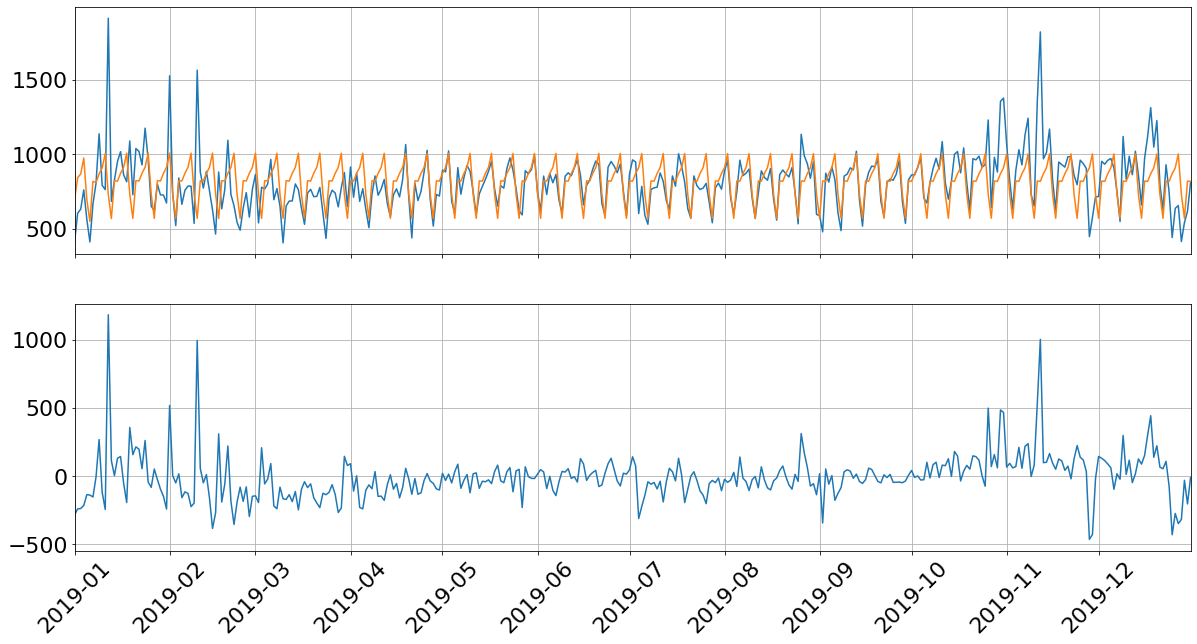

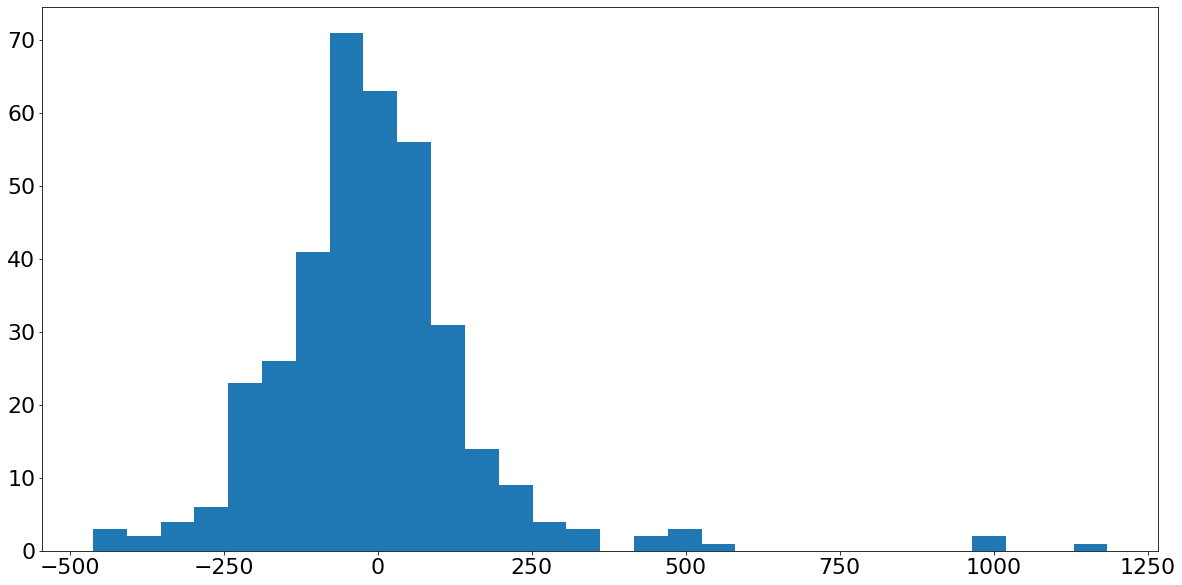

RMSE: 172.99


In [23]:
forecast_wrapper(fit2, test)

The log transformation helped a lot.

Ok, now try a boxcox transformation

C:\Users\smith\anaconda3\lib\site-packages\pmdarima\utils\visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


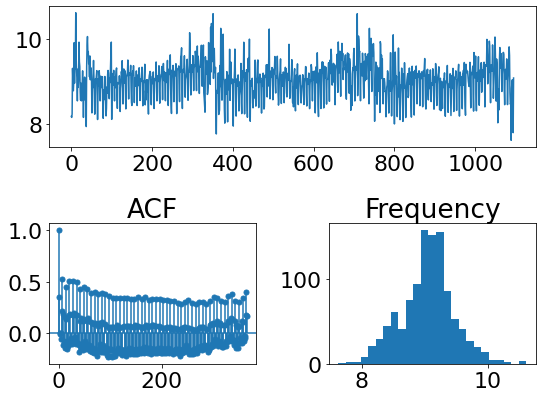

normal test: 0.005556539312436889


In [24]:
train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(train)
tsdisplay(train_bc, lag_max=365)
print(f'normal test: {normaltest(train_bc)[1]}')

In [25]:
#fit3: Box-Cox transformation
fit3 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=7))
])

fit3.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=596.192, Time=2.31 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1200.321, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=835.045, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=7943.152, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=837.851, Time=2.05 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=inf, Time=6.62 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=1036.749, Time=0.86 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=783.976, Time=7.34 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=inf, Time=3.48 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=inf, Time=11.58 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(3,0

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=7, trace=True))])

In [26]:
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1096
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 7)   Log Likelihood                -214.468
Date:                             Mon, 08 Feb 2021   AIC                            444.937
Time:                                     13:27:48   BIC                            484.932
Sample:                                          0   HQIC                           460.070
                                            - 1096                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.003      0.961      0.336      -0.003       0.008
ar.L1          0.4518      0.199      2.265      0.024       0.061       0.843
ma.L1         -0.1485      0.203     -0.732      0.464      -0.546       0.249
ma.L2          0.0505      0.067      0.754      0.451      -0.081       0.182
ma.L3          0.0142      0.049      0.291      0.771      -0.082       0.110
ar.S.L7        0.9995      0.000   2021.319      0.000       0.999       1.000
ma.S.L7       -0.8429      0.018    -47.611      0.000      -0.878      -0.808
sigma2         0.0830      0.002     41.826      0.000       0.079       0.087
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):              1205.18
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.55
Prob(H) (two-sided):                  0.97   Kurtosis:                         8.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

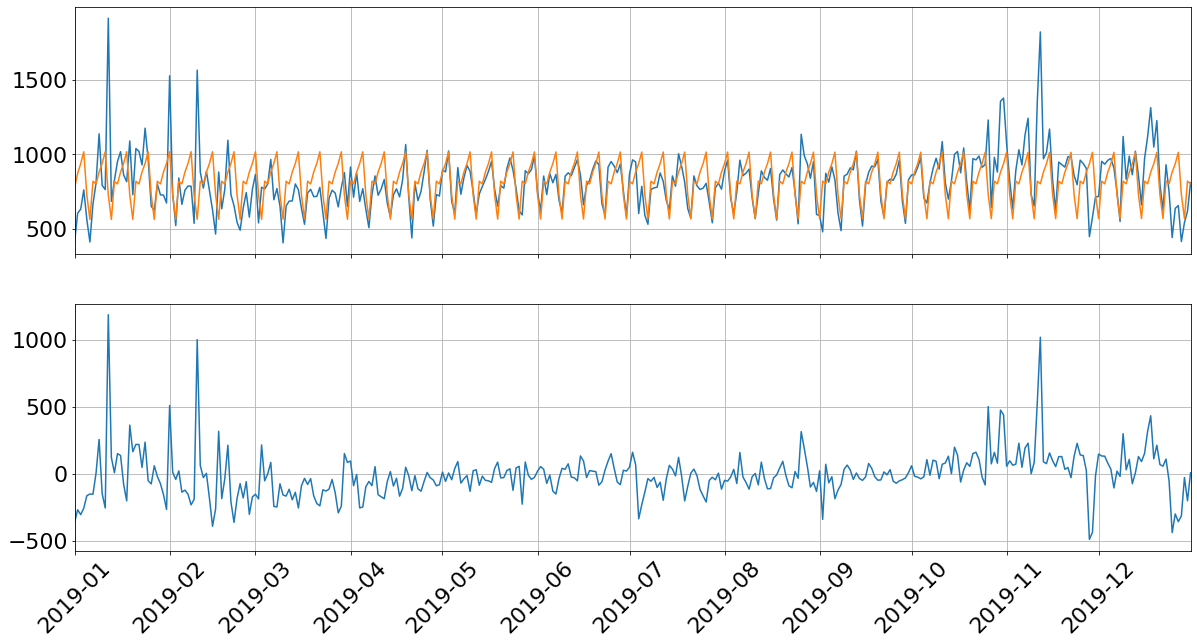

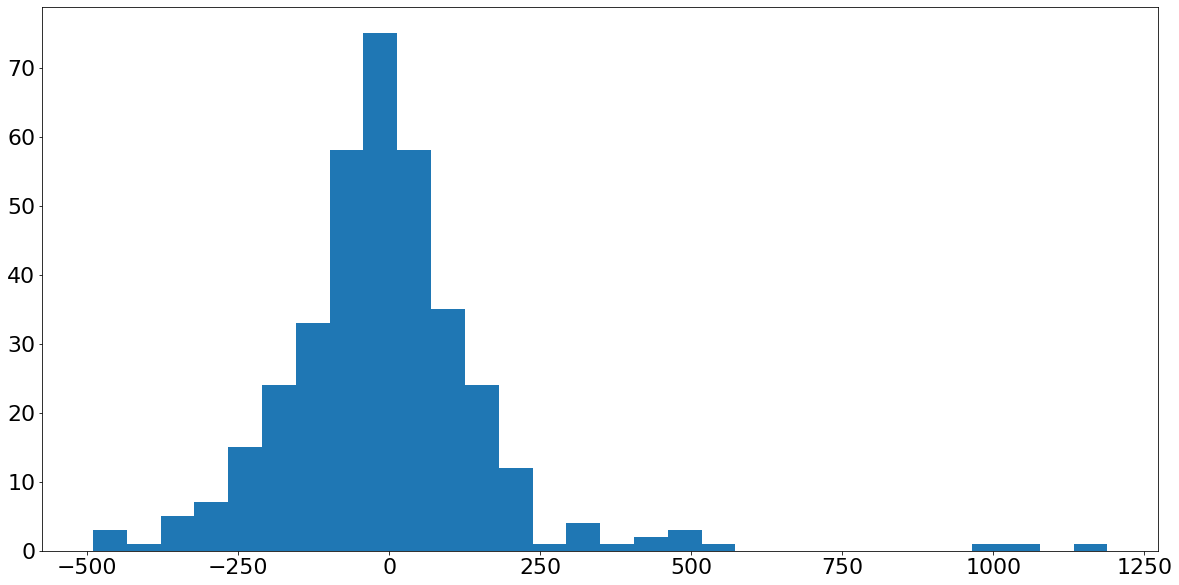

RMSE: 177.01


In [27]:
forecast_wrapper(fit3, test)

Summary of RMSE results (using 2019 test data):
- fit1, No transformation: 192.92
- fit2, Log transformation: 172.99
- fit3, Boxcox transformation: 177.01

It looks like the log transformation works the best, but only by a bit.

Not using a transformation results in a model that approximates the average. Using either log/box-cox transformation yields a model that matches the summer months well, but misses the annual seasonality.

Now, let's train this same model on the log-transformed 2016-2019 dataset, then predict what a "norma" 2020 year would have been.

In [28]:
train = df_daily[df_daily.index.year<2020].dropna()
test = df_daily[df_daily.index.year==2020].dropna()

fit4 = Pipeline([
    ('log', LogEndogTransformer(lmbda=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=7))
])

fit4.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-836.213, Time=3.22 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-89.429, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-562.978, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=9703.179, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=-561.098, Time=2.22 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=-836.096, Time=14.17 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=-292.353, Time=1.30 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=-632.679, Time=10.08 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=inf, Time=4.55 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=-641.697, Time=13.87 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=24.534, Time=2.91 sec
 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=3

Pipeline(steps=[('log', LogEndogTransformer()),
                ('arima', AutoARIMA(m=7, trace=True))])

In [29]:
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1461
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 7)   Log Likelihood                 523.374
Date:                             Mon, 08 Feb 2021   AIC                          -1030.747
Time:                                     13:30:16   BIC                           -988.452
Sample:                                          0   HQIC                         -1014.970
                                            - 1461                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      1.023      0.306      -0.001       0.002
ar.L1          0.6741      0.065     10.389      0.000       0.547       0.801
ma.L1         -0.5059      0.069     -7.338      0.000      -0.641      -0.371
ma.L2          0.1186      0.027      4.370      0.000       0.065       0.172
ma.L3          0.0191      0.033      0.585      0.558      -0.045       0.083
ar.S.L7        0.9997      0.000   3798.302      0.000       0.999       1.000
ma.S.L7       -0.8720      0.014    -60.474      0.000      -0.900      -0.844
sigma2         0.0278      0.001     52.931      0.000       0.027       0.029
===================================================================================
Ljung-Box (L1) (Q):                  19.40   Jarque-Bera (JB):              2491.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.54
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

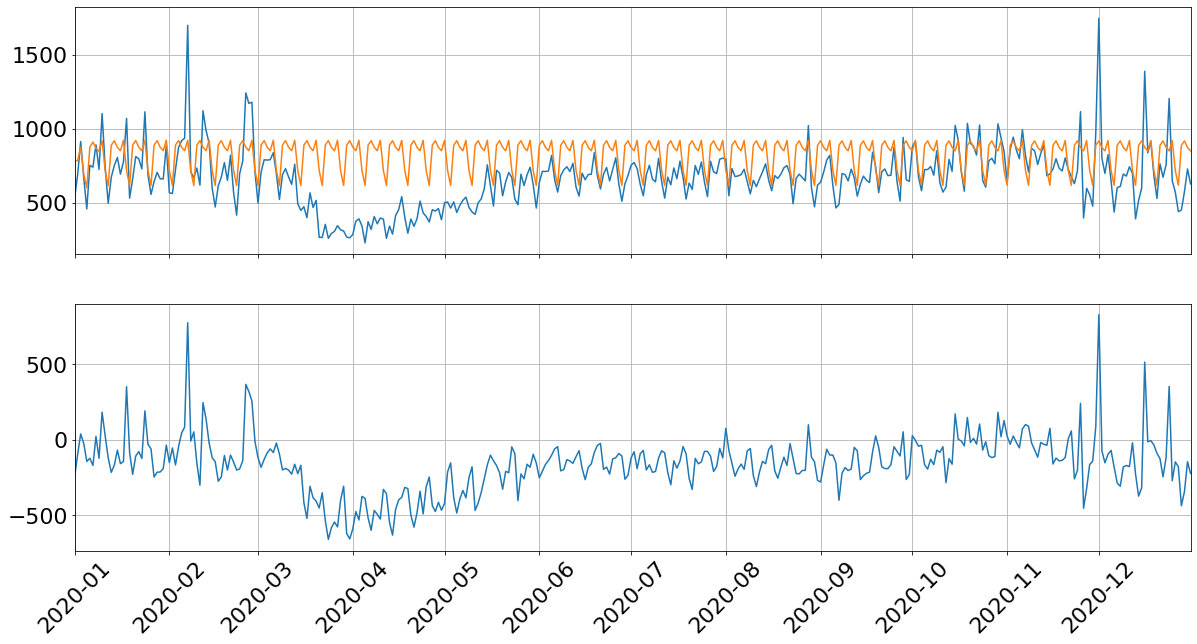

RMSE: 246.71


In [30]:
forecast_wrapper(fit4, test)

# Testing for Stationarity

We will use the augmented Dicky-Fuller test (ADF) to test for stationarity.

In [31]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [32]:
train = df_daily[df_daily.index.year<2019].dropna()
test = df_daily[df_daily.index.year==2019].dropna()
pred = df_daily[df_daily.index.year==2020].dropna()

result = adfuller(test)
print(f'ADF Statistic: {result[0]:5.5f}')
print(f'p-value: {result[1]:5.5f}')
print(f'n_lags = {result[2]}')
print(f'n_obs = {result[3]}')
print(f'Critical values')
for key, value in result[4].items():
    print(f'   {key}: {value:3.3f}')

ADF Statistic: -2.86269
p-value: 0.04986
n_lags = 15
n_obs = 349
Critical values
   1%: -3.449
   5%: -2.870
   10%: -2.571


If we look at a single year (2019, test), we see a p-value of 0.04986 and the ADF statistic is approximately equal to the 5% critical value. This suggests that we can say with roughly 5% confidence that the data is stationary.



The p-value is smaller than 0.05, but the ADF statistic is higher than the critical values.

We test the data for stationarity by plotting the autocorrelation plot over the course of 1 year.

In [33]:
train = df_daily[df_daily.index.year<2019].dropna()
test = df_daily[df_daily.index.year==2019].dropna()
pred = df_daily[df_daily.index.year==2020].dropna()

# Original Series
fig, ax = plt.subplots(4, 2, sharex='col', figsize=(20, 15))
ax[0, 0].plot(train.index, train.NumCrashes)
ax[0, 0].set_title('Original Series')
plot_acf(train.NumCrashes, ax=ax[0, 1], lags=370)

# 1st Differencing
ax[1, 0].plot(train.index, train.NumCrashes.diff())
ax[1, 0].set_title('1st Order Differencing')
plot_acf(train.NumCrashes.diff().dropna(), ax=ax[1, 1], lags=370)

# 2nd Differencing
ax[2, 0].plot(train.index, train.NumCrashes.diff().diff())
ax[2, 0].set_title('2nd Order Differencing')
plot_acf(train.NumCrashes.diff().diff().dropna(), ax=ax[2, 1], lags=370)

# 3rd Differencing
ax[3, 0].plot(train.index, train.NumCrashes.diff().diff())
ax[3, 0].set_title('3nd Order Differencing')
plot_acf(train.NumCrashes.diff().diff().diff().dropna(), ax=ax[3, 1], lags=370)

ax[1, 1].set_ylim(-0.5, 0.5)
ax[2, 1].set_ylim(-0.5, 0.5)
ax[3, 1].set_ylim(-0.3, 0.3)
ax[-1, 0].tick_params(axis='x', rotation=45)
plt.subplots_adjust(hspace=0.3)
plt.show()

We see that, even with 3rd order differencing, the daily dataset is not stationary. This makes sense, since we know the data has a weekly period.

# Multi-Seasonality using TBATS

Our data clearly has at least two frequency components (weekly, annual), and due to leap years, we have non-integer periods (1 year = 365.25 days). Neither SARIMA nor HWES can handle these issues. The so-called "TBATS" method, described in this [2012 paper](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771) ([non-paywall link](https://robjhyndman.com/papers/ComplexSeasonality.pdf)), can address both of these issues:

- BATS = Box-Cox transform + ARMA errors + Trend + Seasonal components
- TBATS = Trigonometric + Box-Cox transform + ARMA errors + Trend + Seasonal components

We use [this package](https://github.com/intive-DataScience/tbats) to implement TBATS in python. This [blog post](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a) by the package authors provides a brief overview of the performance differences between TBATS and SARIMAX.

In [34]:
train = df_daily[df_daily.index.year<2019].dropna()
test = df_daily[df_daily.index.year==2019].dropna()
pred = df_daily[df_daily.index.year==2020].dropna()

# create estimator class
estimator = TBATS(
    seasonal_periods=[7, 365.25],
    use_arma_errors=None,  # shall try models with and without ARMA
    use_box_cox=None,  # will not use Box-Cox
    use_trend=None,  # will try models with trend and without it
    use_damped_trend=None,  # will try models with damping and without it
    show_warnings=False,  # will not be showing any warnings for chosen model
)

# fit the model to training data
fitted_model = estimator.fit(train.NumCrashes)

# predict
y_forecasted, confidence_info = fitted_model.forecast(steps=test.shape[0], confidence_level=0.95)

In [35]:
print(fitted_model.summary())

Use Box-Cox: True
Use trend: False
Use damped trend: False
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 16]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000056
Smoothing (Alpha): 0.034967
Seasonal Parameters (Gamma): [-2.59536930e-04  1.38041509e-03 -2.06344587e-03 -1.60633849e-05]
AR coefficients []
MA coefficients []
Seed vector [ 6.61502488e+00  5.19032582e-02  1.31284795e-01  1.01380524e-02
 -1.61633175e-01  5.12705478e-03  4.29960067e-02  5.12148824e-02
  8.64456514e-04  3.24853611e-03 -1.72498766e-02  7.23692087e-03
  7.34451066e-03 -4.54128394e-03 -1.15740124e-02 -2.70027563e-02
 -2.09133978e-02 -3.55127799e-03 -2.06641563e-02 -2.60612776e-02
 -2.56311126e-02 -7.78529251e-04 -6.75560664e-03 -6.20198706e-02
 -5.66818481e-02  1.22479600e-02  5.02919188e-03 -1.80291477e-03
 -9.15910994e-03 -2.75674126e-03 -8.10006502e-03  1.17099983e-02
  9.57858434e-03  3.07259495e-02  3.52251049e-02  2.83742825e-02
  6.80510315e-03  1.47641388e-02  1.08418594e-02]

AIC 18256.467599


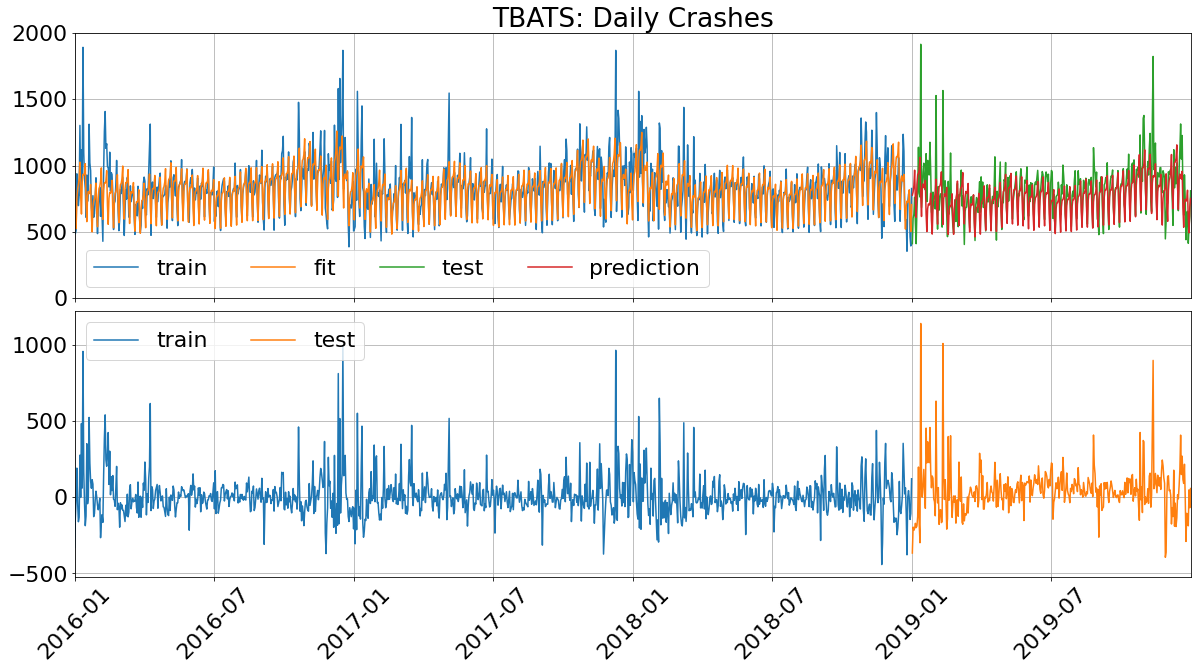

TBATS RMSE = 164.0


In [36]:
# plot the fit
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(train.index, fitted_model.y, label='train')
ax[0].plot(train.index, fitted_model.y_hat, label='fit')
ax[0].plot(test.index, test.NumCrashes, label='test')
ax[0].plot(test.index, y_forecasted, label='prediction')
ax[0].legend(frameon=True, ncol=4)
ax[0].set_ylim(0, 2000)
ax[0].grid()

ax[1].plot(train.index, fitted_model.resid, label='train')
ax[1].plot(test.index, test.NumCrashes-y_forecasted, label='test')
ax[1].legend(frameon=True, ncol=2)
ax[1].grid()

ax[0].set_title('TBATS: Daily Crashes')
ax[0].set_xlim(train.index.min(), test.index.max())
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.05)
plt.show()

# zoom in on the final year
fig, ax = plt.subplots(2, sharex=True)
# ax.plot(train.index, train.NumCrashes, label='train', lw=3)
ax[0].plot(test.index, test.NumCrashes, label='test', lw=3, c='k')
ax[0].plot(test.index, y_forecasted, label='prediction', lw=3, c='r')
ax[0].fill_between(test.index, confidence_info['lower_bound'], confidence_info['upper_bound'], alpha=0.2, color='r')
ax[0].legend(frameon=True, ncol=2)
ax[0].grid()
ax[1].plot(test.index, test.NumCrashes-y_forecasted)
ax[1].grid()
plt.xticks(rotation=45)
ax[0].set_xlim(test.index.min(), test.index.max())
ax[0].set_title(f'TBATS: Daily Crashes (C.I.={confidence_info["calculated_for_level"]})')
plt.subplots_adjust(hspace=0.05)
plt.show()

print(f'TBATS RMSE = {np.sqrt(mean_squared_error(test.NumCrashes,y_forecasted)):3.1f}')

Let's recap (train: 2016-2018, test:2019):
- fit1, No transformation: 192.92
- fit2, Log transformation: 172.99
- fit3, Boxcox transformation: 177.01
- TBATS: 162.1

Now that we have shown that TBATS outperforms HWES, we will use it to quantify the drop in car crash activity for the 2020 year.

In [37]:
train = df_daily[df_daily.index.year<2020].dropna()
test = df_daily[df_daily.index.year==2020].dropna()

# create estimator
estimator = TBATS(
    seasonal_periods=[7, 365.25],
    use_arma_errors=None,  # shall try models with and without ARMA
    use_box_cox=True,  # will not use Box-Cox
    use_trend=None,  # will try models with trend and without it
    use_damped_trend=None,  # will try models with damping and without it
    show_warnings=False,  # will not be showing any warnings for chosen model
)

# fit model
fitted_model = estimator.fit(train.NumCrashes)

# make predictions
y_forecasted, confidence_info = fitted_model.forecast(steps=test.shape[0], confidence_level=0.95)
resid = test.NumCrashes - y_forecasted

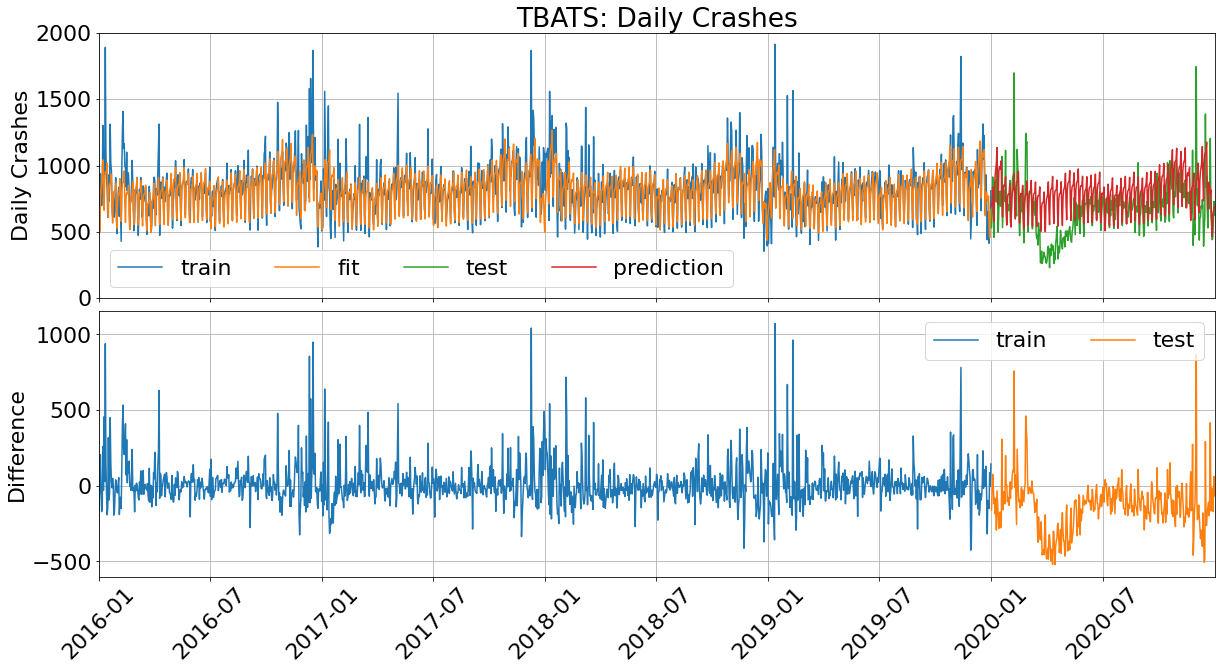

TBATS RMSE = 215.9


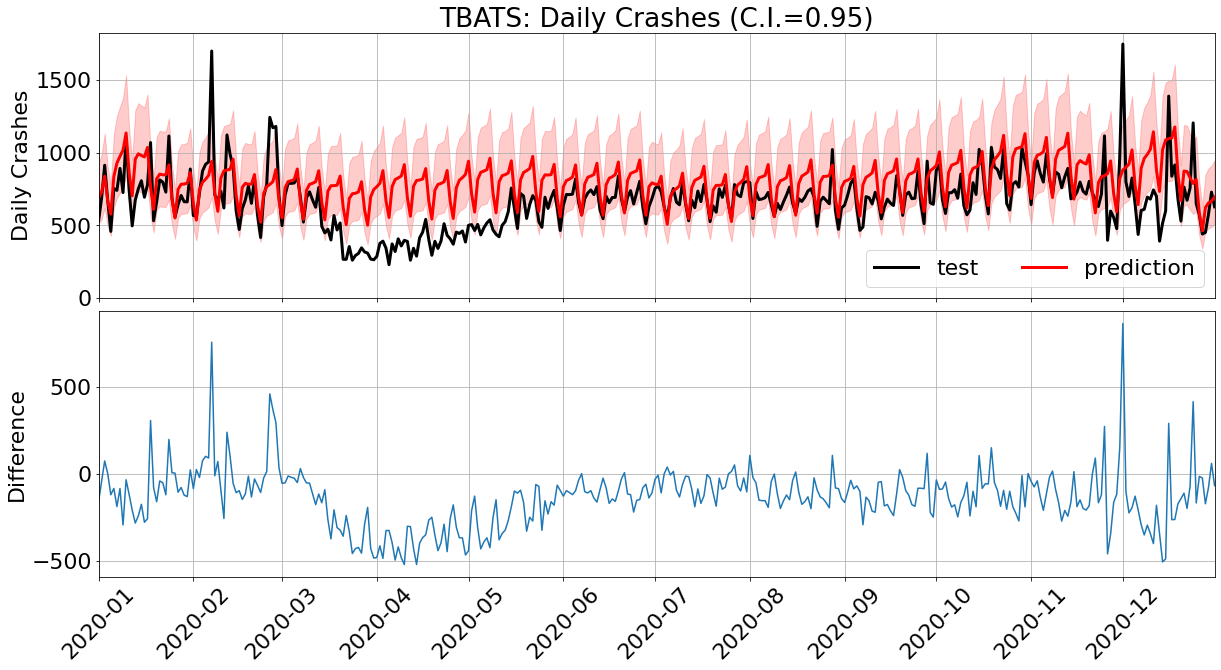

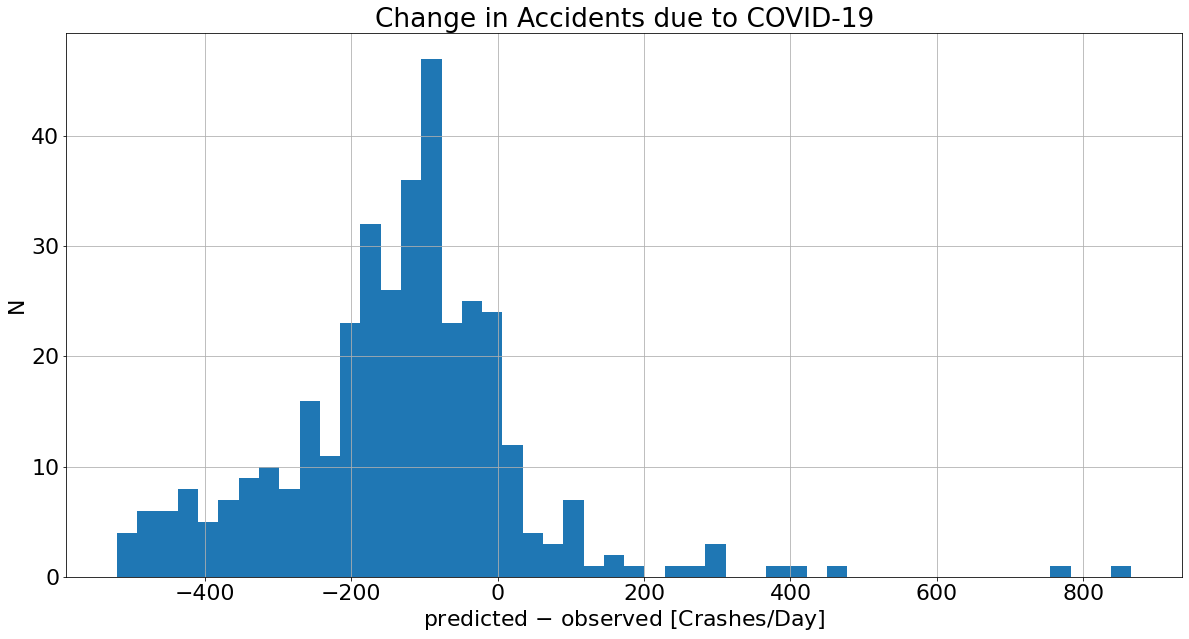

In [38]:
# plot the fit
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(train.index, fitted_model.y, label='train')
ax[0].plot(train.index, fitted_model.y_hat, label='fit')
ax[0].plot(test.index, test.NumCrashes, label='test')
ax[0].plot(test.index, y_forecasted, label='prediction')
ax[0].legend(frameon=True, ncol=4)
ax[0].set_ylim(0, 2000)
ax[0].set_ylabel('Daily Crashes')
ax[0].grid()

ax[1].plot(train.index, fitted_model.resid, label='train')
ax[1].plot(test.index, test.NumCrashes-y_forecasted, label='test')
ax[1].legend(frameon=True, ncol=2)
ax[1].grid()

ax[0].set_title('TBATS: Daily Crashes')
ax[0].set_xlim(train.index.min(), test.index.max())
ax[1].set_ylabel('Difference')
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.05)
plt.show()

print(f'TBATS RMSE = {np.sqrt(mean_squared_error(test.NumCrashes,y_forecasted)):3.1f}')

# plot only the 2020 data
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(test.index, test.NumCrashes, label='test', lw=3, c='k')
ax[0].plot(test.index, y_forecasted, label='prediction', lw=3, c='r')
ax[0].fill_between(test.index, confidence_info['lower_bound'], confidence_info['upper_bound'], alpha=0.2, color='r')
ax[0].legend(frameon=True, ncol=2)
ax[0].set_ylim(0)
ax[0].grid()
ax[0].set_ylabel('Daily Crashes')

ax[0].set_title(f'TBATS: Daily Crashes (C.I.={confidence_info["calculated_for_level"]})')

ax[1].plot(test.index, resid)
ax[1].grid()
ax[1].set_xlim(test.index.min(), test.index.max())
ax[1].set_ylabel('Difference')
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.05)
plt.show()

# histogram of residual
fig, ax = plt.subplots()
resid.hist(bins=50, ax=ax)
ax.set_xlabel(r'predicted $-$ observed [Crashes/Day]')
ax.set_ylabel('N')
ax.set_title('Change in Accidents due to COVID-19')
plt.show()

Look at day-of-week change in number of crashes:

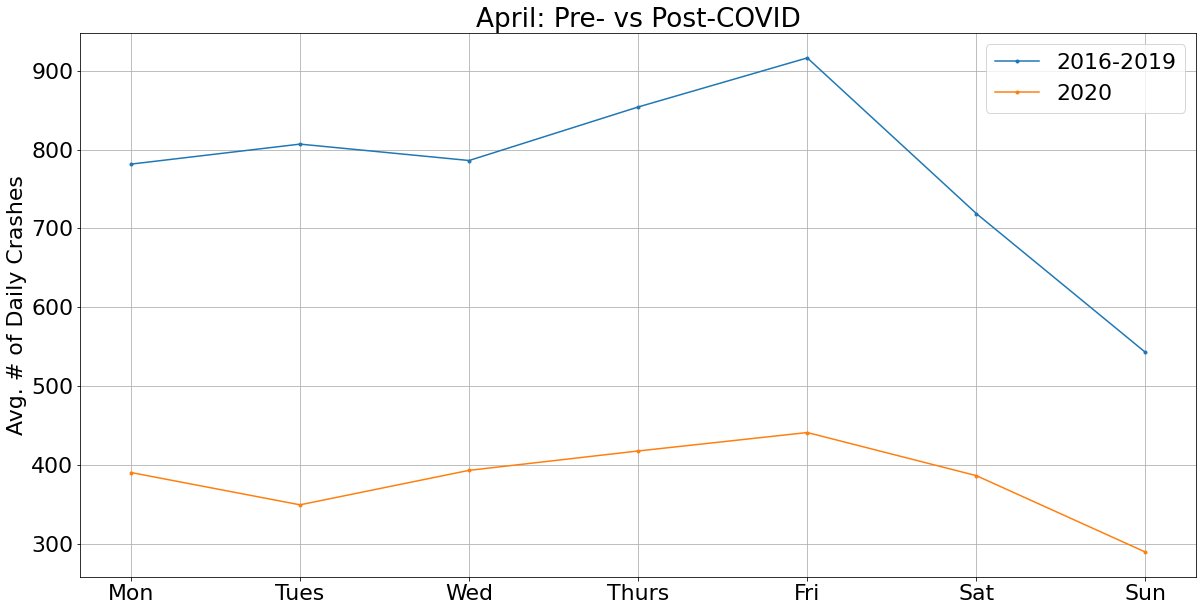

In [39]:
myxticks = [6, 0, 1, 2, 3, 4, 5]
myxlabels = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']

fig, ax = plt.subplots()
ax.plot(train[train.index.month==4].groupby(by=train[train.index.month==4].index.dayofweek).mean().NumCrashes, '.-', label='2016-2019')
ax.plot(test[test.index.month==4].groupby(by=test[test.index.month==4].index.dayofweek).mean().NumCrashes, '.-', label='2020')
ax.legend(frameon=True)
ax.set_xticks(myxticks)
ax.set_xticklabels(myxlabels)
ax.set_ylabel('Avg. # of Daily Crashes')
ax.set_title("April: Pre- vs Post-COVID")
ax.grid()
plt.show()

Try the same analysis on weekly number of crashes:

In [40]:
train = df_weekly[df_weekly.index.year<2020].dropna()
test = df_weekly[df_weekly.index.year==2020].dropna()

# create estimator
estimator = TBATS(
    seasonal_periods=[52],
    use_arma_errors=None,  # shall try models with and without ARMA
    use_box_cox=True,  # will not use Box-Cox
    use_trend=None,  # will try models with trend and without it
    use_damped_trend=None,  # will try models with damping and without it
    show_warnings=False,  # will not be showing any warnings for chosen model
)

# fit model
fitted_model = estimator.fit(train.NumCrashes)

# make predictions
y_forecasted, confidence_info = fitted_model.forecast(steps=test.shape[0], confidence_level=0.95)
resid = test.NumCrashes - y_forecasted

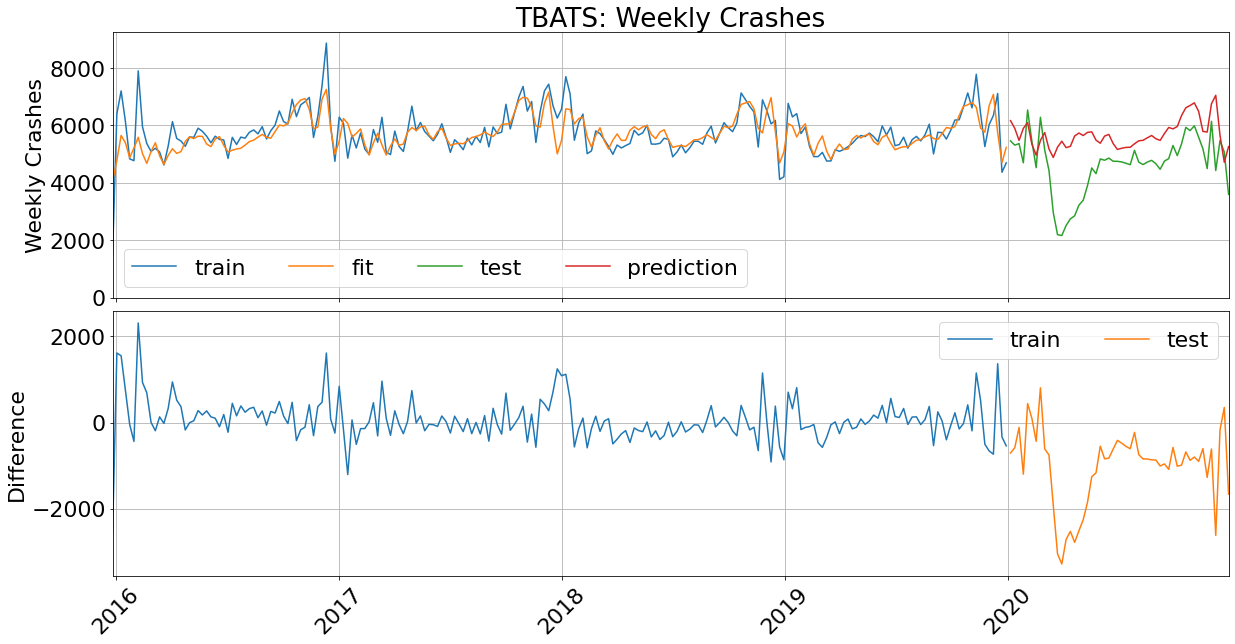

TBATS RMSE = 1346.0


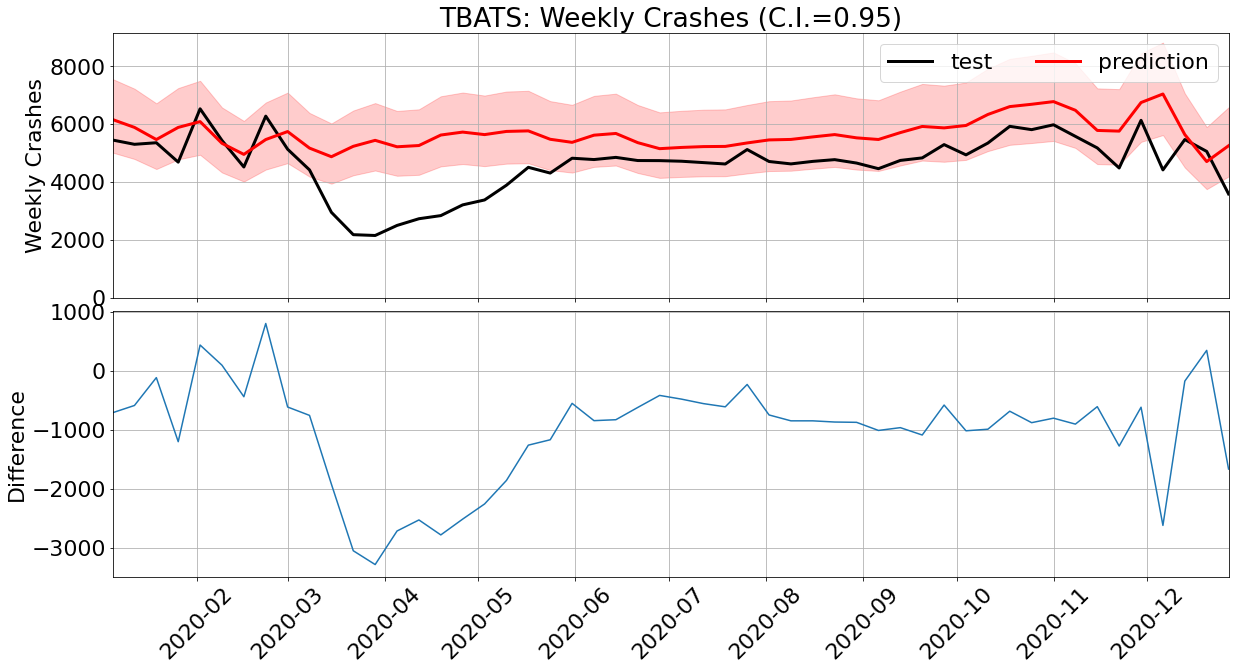

In [41]:
# plot the fit
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(train.index, fitted_model.y, label='train')
ax[0].plot(train.index, fitted_model.y_hat, label='fit')
ax[0].plot(test.index, test.NumCrashes, label='test')
ax[0].plot(test.index, y_forecasted, label='prediction')
ax[0].legend(frameon=True, ncol=4)
ax[0].set_ylim(0)
ax[0].set_ylabel('Weekly Crashes')
ax[0].grid()

ax[1].plot(train.index, fitted_model.resid, label='train')
ax[1].plot(test.index, test.NumCrashes-y_forecasted, label='test')
ax[1].legend(frameon=True, ncol=2)
ax[1].grid()

ax[0].set_title('TBATS: Weekly Crashes')
ax[0].set_xlim(train.index.min(), test.index.max())
ax[1].set_ylabel('Difference')
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.05)
plt.show()

print(f'TBATS RMSE = {np.sqrt(mean_squared_error(test.NumCrashes,y_forecasted)):3.1f}')

# plot only the 2020 data
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(test.index, test.NumCrashes, label='test', lw=3, c='k')
ax[0].plot(test.index, y_forecasted, label='prediction', lw=3, c='r')
ax[0].fill_between(test.index, confidence_info['lower_bound'], confidence_info['upper_bound'], alpha=0.2, color='r')
ax[0].legend(frameon=True, ncol=2)
ax[0].set_ylim(0)
ax[0].grid()
ax[0].set_ylabel('Weekly Crashes')

ax[0].set_title(f'TBATS: Weekly Crashes (C.I.={confidence_info["calculated_for_level"]})')

ax[1].plot(test.index, resid)
ax[1].grid()
ax[1].set_xlim(test.index.min(), test.index.max())
ax[1].set_ylabel('Difference')
plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.05)
plt.show()

# histogram of residual
fig, ax = plt.subplots()
resid.hist(bins=20, ax=ax)
ax.set_xlabel(r'predicted $-$ observed [Crashes/Week]')
ax.set_ylabel('N')
ax.set_title('Change in Accidents due to COVID-19')
plt.show()